In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
import scipy.integrate
from operators.SW_sqrt import RHS, psi_ln_sw
from operators.SW import solve_poisson_equation, integral_I0, integral_I1, integral_I2

In [3]:
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 

# Nonlinear Landau Damping

In [5]:
# set up configuration parameters
# number of mesh points in x 
Nx = 101
# number of spectral expansions
Nv = 100
# epsilon displacement in initial electron distribution 
epsilon = 0.5
# velocity scaling of electron and ion
alpha_e = np.sqrt(1)
alpha_i = np.sqrt(1/1863)
# x grid is from 0 to L
L = 4* np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L/(Nx-1)
# time stepping 
dt = 1e-3
# final time (nondimensional)
T = 10.
# total number of time stepping
Nt = int(T/dt)
# velocity scaling 
u_e = 0
u_i = 0 
# mass normalized
m_e = 1
m_i = 1863
# charge normalized
q_e = -1
q_i = 1

In [6]:
# velocity grid for plotting purposes
v = np.linspace(-4, 4, 10000)
# spatial grid 
x = np.linspace(0, L, Nx)

In [7]:
# initial condition of the first expansion coefficient
C_0e = 1 / (np.sqrt(2 * np.sqrt(np.pi))) * (1 + epsilon * np.cos(0.5*x)) / alpha_e
C_0i = 1 / (np.sqrt(2 * np.sqrt(np.pi))) * np.ones(Nx) / alpha_i

In [8]:
# the distribution function of electrons and protons for plotting purposes
f_0e = np.outer(C_0e, psi_ln_sw((v-u_e)/alpha_e, n=0))
f_0i = np.outer(C_0i, psi_ln_sw((v-u_i)/alpha_i, n=0))

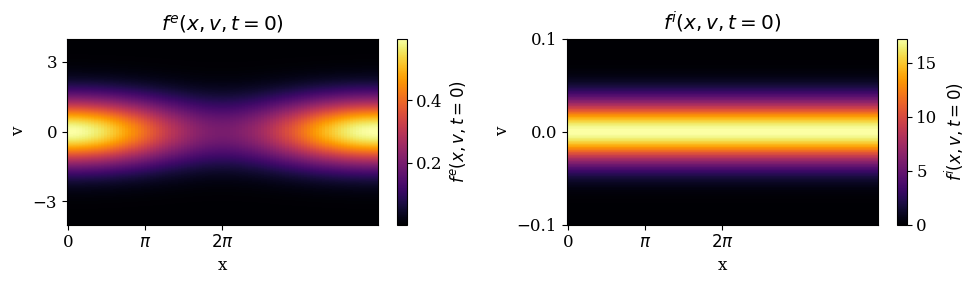

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, f_0e.T, cmap="inferno", vmax=np.max(f_0e))
ax[0].set_xlabel("x")
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)

cbar.ax.set_ylabel('$f^{e}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, f_0i.T, cmap="inferno")
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_ylim(-0.1, 0.1)
ax[1].set_yticks([-0.1, 0, 0.1])
ax[1].set_ylabel("v")
ax[1].set_xlabel("x")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{i}(x, v, t=0)$")
plt.tight_layout()
plt.savefig("../figs/SW/nonlinear_landau/poisson/initial_condition_landau_damping.png", dpi=600)

In [10]:
# initialize states (electrons and ions) 
states_e = np.zeros((Nv, Nx-1, Nt))
states_i = np.zeros((Nv, Nx-1, Nt))

In [11]:
# initialize the expansion coefficients
states_e[0, :, 0] = C_0e[:-1]
states_i[0, :, 0] = C_0i[:-1]

# initial condition of the semi-disretized ODE
y0 = np.append(states_e[:, :, 0].flatten("C"), states_i[:, :, 0].flatten("C"))

In [12]:
sol_midpoint_u = np.load("../data/SW/nonlinear_landau/poisson/sol_midpoint_u_100_newton.npy")
sol_midpoint_t = np.load("../data/SW/nonlinear_landau/poisson/sol_midpoint_t_100_newton.npy")

print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(10005, 1001)
(1001,)


In [13]:
# initialize the electric potential
E_midpoint = np.zeros((Nx-1, len(sol_midpoint_t)))

In [14]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))

for ii in range(len(sol_midpoint_t)):
    for jj in range(Nv):
        # unwind the flattening in order to solve the nonlinear system
        state_e_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
        state_i_midpoint[0, :, ii] = 1 / (np.sqrt(2 * np.sqrt(np.pi))) * np.ones(Nx - 1) / alpha_i
    
    E_midpoint[:, ii] = solve_poisson_equation(state_e=state_e_midpoint[:, :, ii], 
                       state_i=state_i_midpoint[:, :, ii], 
                       alpha_e=alpha_e, 
                       alpha_i=alpha_i, 
                       dx=dx, 
                       Nx=Nx-1, 
                       Nv=Nv, solver="gmres", order_fd=2, L=L)

gmres error == 2.997602166487923e-16
gmres error == 3.774758283725532e-16
gmres error == 4.973799150320702e-16
gmres error == 4.130029651605582e-16
gmres error == 2.842170943040401e-16
gmres error == 4.063416270128073e-16
gmres error == 3.9745984281580605e-16
gmres error == 2.331468351712829e-16
gmres error == 3.6637359812630164e-16
gmres error == 4.729550084903167e-16
gmres error == 4.75175454539567e-16
gmres error == 3.6415315207705137e-16
gmres error == 2.8199664825478977e-16
gmres error == 3.6859404417555195e-16
gmres error == 3.8635761256955447e-16
gmres error == 3.9523939676655573e-16
gmres error == 3.61932706027801e-16
gmres error == 3.4416913763379854e-16
gmres error == 4.063416270128073e-16
gmres error == 5.24025267623074e-16
gmres error == 3.4416913763379854e-16
gmres error == 3.907985046680551e-16
gmres error == 3.3528735343679723e-16
gmres error == 5.906386491005833e-16
gmres error == 5.573319583618285e-16
gmres error == 3.375077994860476e-16
gmres error == 3.90798504668055

In [15]:
E1_midpoint = np.zeros(len(sol_midpoint_t))


for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

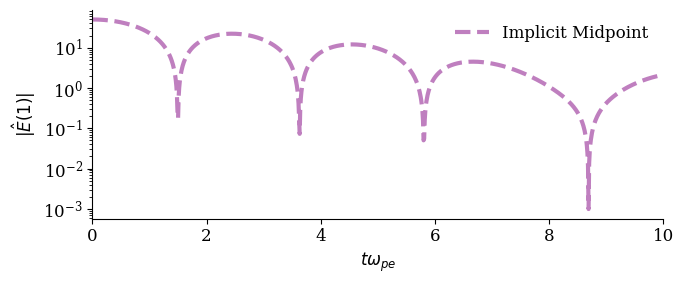

In [16]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "--", c="purple", alpha=0.5, linewidth=3, label="Implicit Midpoint") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t \omega_{pe}$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW/nonlinear_landau/poisson/electric_field_SW.png", dpi=600)

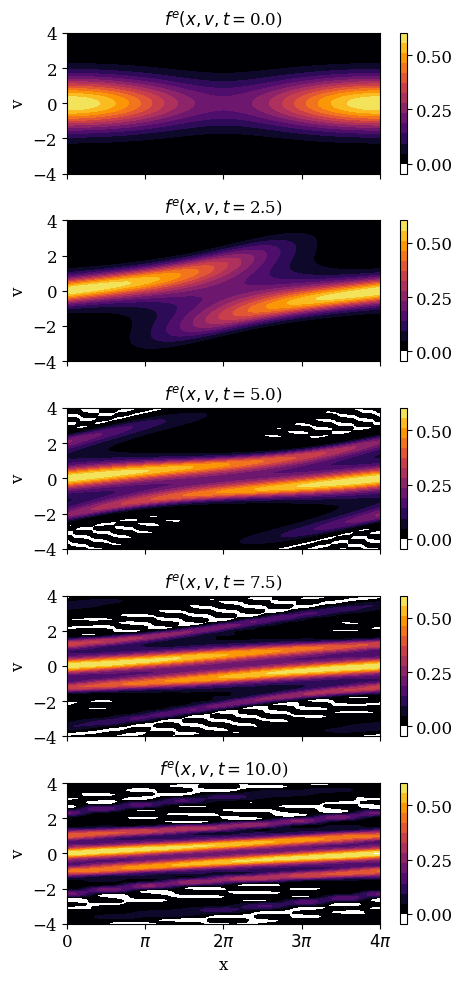

In [17]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(5, 10))
for tt, ii in enumerate(range(0, len(sol_midpoint_t), int(len(sol_midpoint_t)/4))):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution += np.outer(np.append(state_e_midpoint[jj, :, ii], state_e_midpoint[jj, 0, ii]), psi_ln_sw((v)/alpha_e, n=jj))
    levels = np.append(-0.1, np.linspace(0, 0.65, 15))[:-1]
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)[:-1]
    pos = ax[tt].contourf(x, v, distribution.T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
    ax[tt].set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(round(sol_midpoint_t[ii], 1)) + ")", fontsize=12)
    cbar.ax.set_yticks([0, 0.25, 0.5])
ax[-1].set_xlabel("x")
plt.tight_layout()
plt.savefig("../figs/SW/nonlinear_landau/poisson/nonlinear_landau_evolution_SW.png", dpi=600)

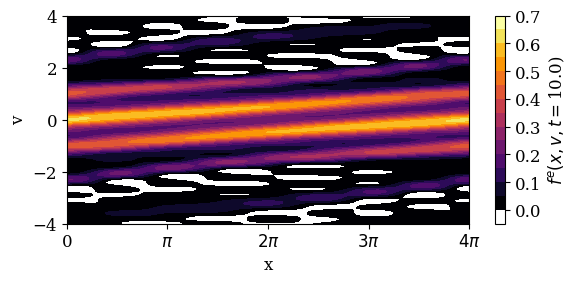

In [18]:
fig, ax = plt.subplots(figsize=(6, 3))
distribution = np.zeros((Nx, len(v)))
for jj in range(Nv):
    distribution += np.outer(np.append(state_e_midpoint[jj, :, -1], state_e_midpoint[jj, 0, -1]), psi_ln_sw((v-u_e)/alpha_e, n=jj))
levels = np.append(-0.1, np.linspace(0, 0.7, 15))
colors = mcp.gen_color(cmap="inferno",n=len(levels)-2)
pos = ax.contourf(x, v, distribution.T, levels=levels, colors=np.append(["w"], colors))
ax.contour(x, v, distribution.T, levels=[0], linewidths=0.00, colors='w')
ax.set_xlabel("x")
ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$",  r"$3\pi$",  r"$4\pi$"])
ax.set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(round(sol_midpoint_t[-1], 2)) + ")", rotation=90)

plt.tight_layout()
plt.savefig("../figs/SW/nonlinear_landau/poisson/electron_distribution_t_10_SW.png", dpi=600)

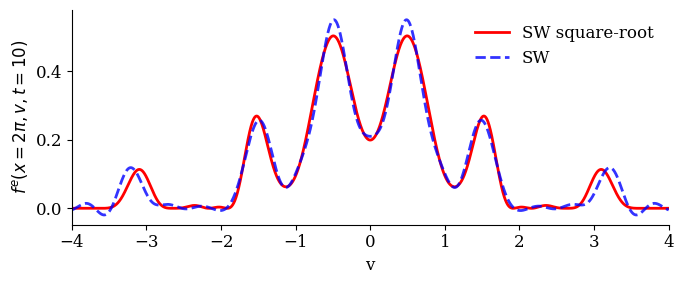

In [19]:
distribution_sw_sqrt = np.load("../data/SW_sqrt/nonlinear_landau/poisson/sw_sqrt_landau_distribution_Nv_101.npy")
fig, ax = plt.subplots(figsize=(7, 3))
_ = ax.plot(v, distribution_sw_sqrt[Nx//2, :], c="red", ls="-", linewidth=2, alpha=1, label="SW square-root")
_ = ax.plot(v, distribution[Nx//2, :], c="blue", ls="--", linewidth=2, alpha=0.8, label="SW")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
ax.set_xlabel("v")
ax.set_ylabel("$f^{e}(x=2\pi, v, t=10)$")
ax.set_xlim(-4, 4)
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/nonlinear_landau/poisson/filamentation_nonlinear_landau.png", dpi=600)

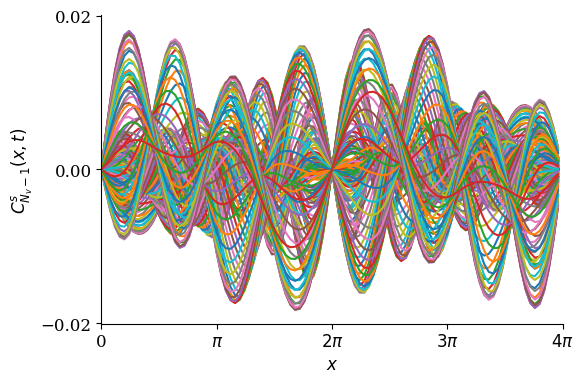

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
_ = plt.plot(x[:-1], state_e_midpoint[-1, :, ::3])
ax.set_xlabel("$x$")
ax.set_ylabel("$C_{N_{v}-1}^{s}(x, t)$")
ax.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi])
ax.set_yticks([-0.02, 0, 0.02])
ax.set_xlim(0, 4*np.pi)
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$", r"$3\pi$", r"$4\pi$"])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("../figs/SW_sqrt/nonlinear_landau/poisson/last_coefficient_central.png")

# Conservation Laws

### Total Mass Conservation

In [21]:
def integral_I0(n, Nv):
    if n < 0:
        return 0
    elif n > Nv - 1:
        return 0
    elif n == 0:
        return np.sqrt(2) * (np.pi ** (1/4))
    elif n % 2 == 1:
        return 0
    else:
        term = np.zeros(Nv)
        term[0] = np.sqrt(2) * (np.pi ** (1/4))
        for m in range(2, Nv):
            term[m] = np.sqrt((m - 1) / m) * term[m - 2]
        return term[n]

In [22]:
def term1(state, ii):
    Nv, Nx, Nt = np.shape(state)
    res = 0
    for m in range(Nv):
        res+= integral_I0(n=m, Nv=Nv)*np.sum(state[m, :, ii])
    return res

In [23]:
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = term1(state=state_e_midpoint, ii=ii)*dx*alpha_e + term1(state=state_i_midpoint, ii=ii)*dx*alpha_i

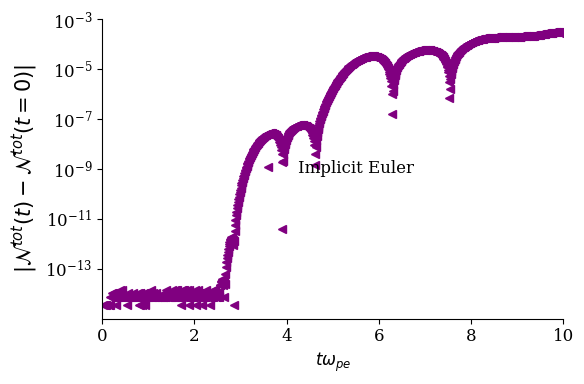

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "<", color="purple", label="Implicit Euler")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t \omega_{pe}$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12, loc='center')
legend.get_frame().set_alpha(0)
plt.tight_layout()

### Total Momentum Conservation

In [25]:
def term2(state, ii, u_s, alpha_s):
    Nv, Nx, Nt = np.shape(state)
    res = 0
    for m in range(1, Nv):
        res += integral_I1(n=m, u_s=u_s, alpha_s=alpha_s, Nv=Nv) * np.sum(state[m, :, ii])
    return res

In [26]:
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = dx*m_e*alpha_e*(term2(state=state_e_midpoint, ii=ii, u_s=u_e, alpha_s=alpha_e))\
                          + dx*m_i*alpha_i*(term2(state=state_i_midpoint, ii=ii, u_s=u_i, alpha_s=alpha_i))

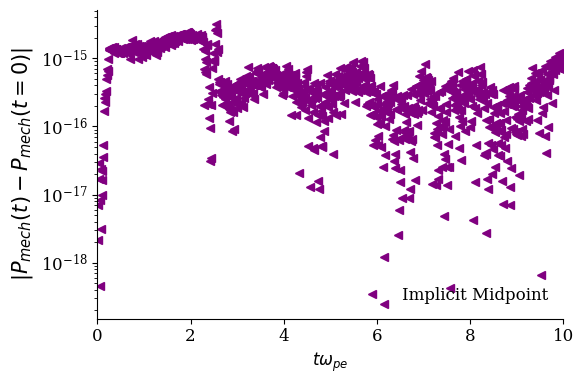

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "<", color="purple", label="Implicit Midpoint")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t \omega_{pe}$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower right')
legend.get_frame().set_alpha(0)
plt.tight_layout()

### Total Energy Conservation

In [28]:
def integral_I0(n, Nv):
    if n == - 2:
        return 0
    elif n == 0:
        return np.sqrt(2) * (np.pi ** (1/4))
    elif n % 2 == 1:
        return 0
    else:
        term = np.zeros(Nv+3)
        term[0] = np.sqrt(2) * (np.pi ** (1/4))
        for m in range(2, Nv+3):
            term[m] = np.sqrt((m - 1) / m) * term[m - 2]
        return term[n]


def integral_I1(n, u_s, alpha_s, Nv):
    if n % 2 == 0:
        return u_s * integral_I0(n=n, Nv=Nv)
    else:
        return alpha_s * np.sqrt(n / 2) * integral_I0(n=n - 1, Nv=Nv) \
             + alpha_s * np.sqrt((n + 1) / 2) * integral_I0(n=n + 1, Nv=Nv)


def integral_I2(n, u_s, alpha_s, Nv):
    if n % 2 == 0:
        return ((2*n+1)*(alpha_s**2) + u_s**2)*integral_I0(n=n, Nv=Nv)
    else:
        return 2*u_s*integral_I1(n=n, u_s=u_s, alpha_s=alpha_s, Nv=Nv)

def integral_I2(n, u_s, alpha_s, Nv):
    if n % 2 == 0:
        return (alpha_s ** 2) * (0.5 * np.sqrt((n + 1) * (n + 2)) * integral_I0(n=n + 2, Nv=Nv) + (
                (2 * n + 1) / 2 + (u_s / alpha_s) ** 2) * integral_I0(n=n, Nv=Nv) + 0.5 * np.sqrt(n * (n - 1)) *
                                 integral_I0(n=n - 2, Nv=Nv))
    else:
        return 2*u_s*integral_I1(n=n, u_s=u_s, alpha_s=alpha_s, Nv=Nv)

In [29]:
def term4(state, ii, u_s, alpha_s, Nv):
    Nv, Nx, Nt = np.shape(state)
    res = 0
    for m in range(0, Nv):
        res += integral_I2(n=m, u_s=u_s, alpha_s=alpha_s, Nv=Nv) * np.sum(state[m, :, ii])
    return res

In [30]:
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = 0.5*dx*m_e*alpha_e*(term4(state=state_e_midpoint, ii=ii, u_s=u_e, alpha_s=alpha_e, Nv=Nv))\
                          + 0.5*dx*m_i*alpha_i*(term4(state=state_i_midpoint, ii=ii, u_s=u_i, alpha_s=alpha_i, Nv=Nv))\
    
    energy_p_midpoint[ii] = dx*(0.5)*np.sum((E_midpoint[:, ii])**2)

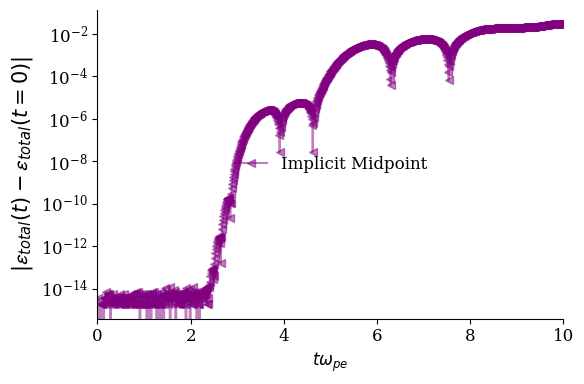

In [31]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-<", alpha=0.5, color="purple", label="Implicit Midpoint")


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t \omega_{pe}$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='center')
legend.get_frame().set_alpha(0)
plt.tight_layout()

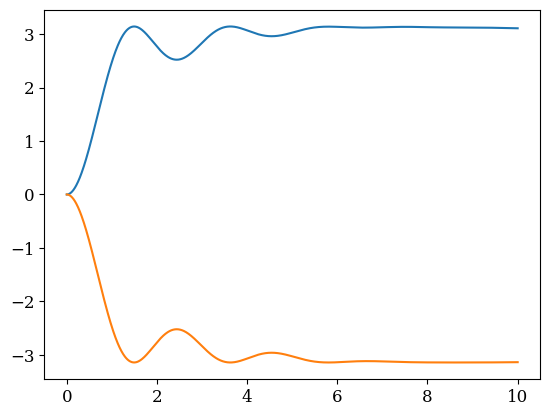

In [32]:
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0])
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0])

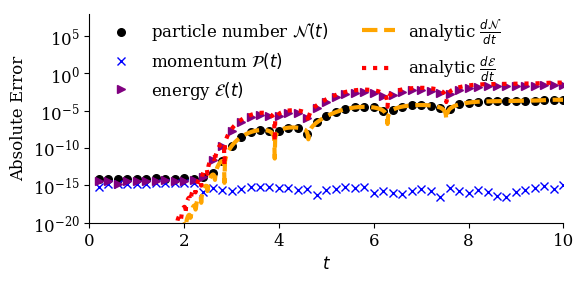

In [33]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 3))

ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), "--", c="orange", linewidth=3, label=r"analytic $\frac{d \mathcal{N}}{dt}$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-5]), ":", c="red", linewidth=3, label=r"analytic $\frac{d \mathcal{E}}{dt}$")
#ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "--", c="red", linewidth=3, label=r"analytic $\frac{d \mathcal{P}}{dt}$")
ax.set_ylim(10**-20, 10**8)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=12, loc="upper left", bbox_to_anchor=(0.,1.06))
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW/nonlinear_landau/poisson/mass_momentum_energy_conservation_100_nonlinear_landau_SW.png", dpi=600)

In [34]:
def L2(state, ii):
    Nv, Nx, Nt = np.shape(state)
    res = 0
    for m in range(Nv):
        res += state[m, :, ii].T @ state[m, :, ii]
    return res

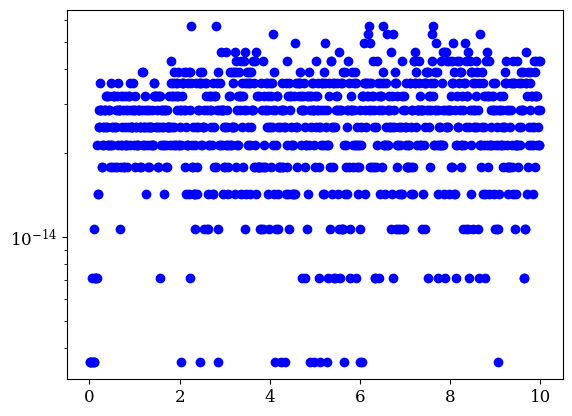

In [35]:
fig, ax = plt.subplots()
for ii in range(len(sol_midpoint_t)):
    ax.scatter(sol_midpoint_t[ii], np.abs(L2(state=state_i_midpoint, ii=ii) - L2(state=state_i_midpoint, ii=0)), c="r")
    ax.scatter(sol_midpoint_t[ii], np.abs(L2(state=state_e_midpoint, ii=ii) - L2(state=state_e_midpoint, ii=0)), c="b")
ax.set_yscale("log")

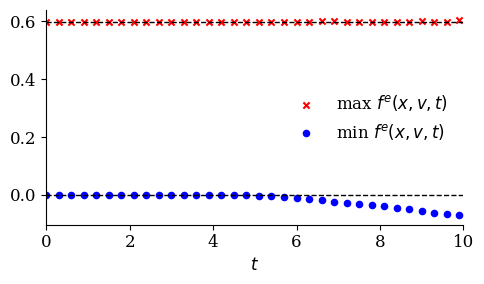

In [36]:
fig, ax = plt.subplots(figsize=(5, 3))
for ii in range(0, len(sol_midpoint_t), 30):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution += np.outer(np.append(state_e_midpoint[jj, :, ii], state_e_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e)/alpha_e, n=jj))
    ax.scatter(sol_midpoint_t[ii], np.nanmax(distribution), marker="x", c="r", s=20)
    ax.scatter(sol_midpoint_t[ii], np.nanmin(distribution), marker="o", c="b", s=20)
    ax.set_xlabel("$t$")
ax.set_xlim(0, 10)
ax.axhline(y=0, c="black", ls="--", linewidth=1)  
ax.axhline(y=0.598413, c="black", ls="--", linewidth=1)  
ax.scatter(np.nan, np.nan, c="r", marker="x", s=20, label="max $f^{e}(x, v, t)$")
ax.scatter(np.nan, np.nan, c="b", marker="o", s=20, label="min $f^{e}(x, v, t)$")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='right')
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
#plt.savefig("../figs/SW/nonlinear_landau/poisson/distribution_maxima_nonlinear_landau_SW.png", dpi=500)

In [36]:
np.max(distribution)

0.6114391202334448